# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')


In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias_na_rows=azdias.isna().any(axis=1).sum()

In [6]:
feat_info.head(3)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
for col in azdias.columns:
    missing_code=feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0]
    missing_code=str.split(missing_code.replace('[', '').replace(']', ''), sep=',')
    def f(x): 
        if str(x) in missing_code:
            return (np.NaN)
        else:
            return (x)
    azdias[col]=azdias[col].apply(f)

In [8]:
# How many rows have NaNs
print('Rows having Nans before conversion', azdias_na_rows)
print('Rows having Nans after conversion', azdias.isna().any(axis=1).sum())

Rows having Nans before conversion 628074
Rows having Nans after conversion 829532


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# First lets find out what is the percentage of Nan in each column
df_nan=azdias.isna().sum()/azdias.shape[0]*100
# Lets check if there are some values that are repeated, forming clusters of columns with missing data. I believe this 
# this is more valuable than a histogram 
np.sort(df_nan.unique())

array([  0.        ,   0.32326438,   0.54464605,   2.05874862,
         8.24700046,   8.2997371 ,  10.45172858,  10.45251402,
        10.51815431,  10.88484226,  10.90818102,  11.14785222,
        11.87135402,  12.07354854,  12.13660809,  12.15355114,
        12.47681551,  13.07363718,  13.59887166,  14.95970135,
        44.02028229,  65.59674873,  76.9554353 ])

In [10]:
# I decide to remove the columns that have more than 13% missing data.
# Lets check these columns
limit_nan_remove=13
df_nan.sort_values(ascending=False)[df_nan.sort_values(ascending=False)>limit_nan_remove]

AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
GEBURTSJAHR     44.020282
KBA05_ANTG1     14.959701
KBA05_BAUMAX    14.959701
KBA05_GBZ       14.959701
KBA05_ANTG2     14.959701
MOBI_REGIO      14.959701
KBA05_ANTG3     14.959701
KBA05_ANTG4     14.959701
REGIOTYP        13.598872
KKK             13.598872
PLZ8_ANTG1      13.073637
PLZ8_ANTG2      13.073637
PLZ8_ANTG3      13.073637
PLZ8_ANTG4      13.073637
PLZ8_GBZ        13.073637
PLZ8_BAUMAX     13.073637
PLZ8_HHZ        13.073637
dtype: float64

In [11]:
#Now we can remove these columns
drop_list_cols=df_nan.sort_values(ascending=False)[df_nan.sort_values(ascending=False)>limit_nan_remove].index
azdias.drop(drop_list_cols, axis=1, inplace=True)

In [12]:
# the cols to be droped
drop_list_cols

Index(['AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'KBA05_ANTG1',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KBA05_ANTG2', 'MOBI_REGIO', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'REGIOTYP', 'KKK', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_GBZ', 'PLZ8_BAUMAX', 'PLZ8_HHZ'],
      dtype='object')

In [13]:
# Lets check the na cluster of the remaining columns
df_nan=azdias.isna().sum()/azdias.shape[0]*100
df_nan.sort_values(ascending=True).unique()

array([  0.        ,   0.32326438,   0.54464605,   2.05874862,
         8.24700046,   8.2997371 ,  10.45172858,  10.45251402,
        10.51815431,  10.88484226,  10.90818102,  11.14785222,
        11.87135402,  12.07354854,  12.13660809,  12.15355114,  12.47681551])

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### I decided to remove all the colums where more than 13% of the data is missing. These columns give for example some description about the persons personality or saving behaviour. Since this data is missing I prefer to remove these columns to avoid unwanted bias.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
# How many rows have NaNs
print(" The rows of the data " , azdias.shape[0]) 
print(" The rows containing Nans are " , azdias.isna().any(axis=1).sum())

 The rows of the data  891221
 The rows containing Nans are  193672


In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#first let check how many nans do we find per row, in percentage of the total number of columns
np.sort(azdias.isna().sum(axis=1).unique()/azdias.shape[1])

array([ 0.        ,  0.01515152,  0.03030303,  0.04545455,  0.06060606,
        0.07575758,  0.09090909,  0.10606061,  0.12121212,  0.13636364,
        0.15151515,  0.16666667,  0.18181818,  0.1969697 ,  0.21212121,
        0.22727273,  0.24242424,  0.25757576,  0.27272727,  0.28787879,
        0.3030303 ,  0.31818182,  0.33333333,  0.34848485,  0.36363636,
        0.42424242,  0.43939394,  0.45454545,  0.48484848,  0.5       ])

In [16]:
# I decide to remove the rows which have more than 15% of missing data, therefore which have a maximal nr of na per row =
max_na=azdias.shape[1]*0.15
max_na

9.9

In [17]:
# With tis info I create two data frames, one with low and one with with na content. LEts chekc the shape of theses data frames
filter_list=azdias.isna().sum(axis=1)>=max_na
azdias_low_na=azdias[~filter_list]
azdias_low_na.shape

(793309, 66)

In [18]:
azdias_high_na=azdias[filter_list]
azdias_high_na.shape

(97912, 66)

In [19]:
# The list of columns with at most 0 nas in the low na dataframe
azdias.columns[azdias_low_na.isna().sum()==0]

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ',
       'TITEL_KZ', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'ONLINE_AFFINITAET'],
      dtype='object')

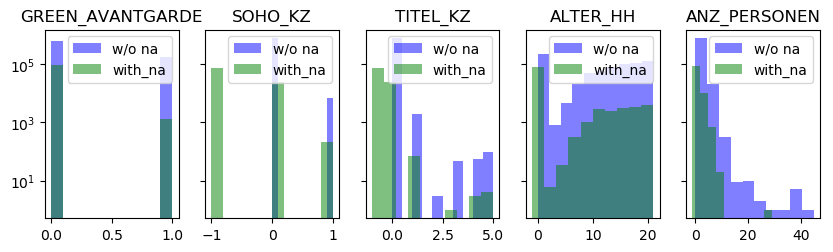

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# In the plot below the nas of the dataframe with high na content are coded as -1 

cols=['GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL']

fig, axes = plt.subplots(1, 5, figsize=(10,2.5), dpi=100, sharex=False, sharey=True)

for i, ax in enumerate(axes):
    axes[i].hist(azdias_low_na[cols[i]].fillna(-1), log=True, color='b', alpha=0.5, label='w/o na')
    axes[i].hist(azdias_high_na[cols[i]].fillna(-1), log=True, color='g', alpha=0.5, label='with_na')
    axes[i].set_title(cols[i])
    axes[i].legend()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

#### The histograms above shows that the dataset that has more NaN values does not represent the same persons as those represented by the data withtout NaNs. The sets are qualitatively different, the ratios of the values are not equivalent, therefore it makes sense to remove them for analysis to avoid introducing bias.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
feat_info.groupby('type')['type'].describe()

,count,unique,top,freq
type,,,,
categorical,21,1,categorical,21
interval,1,1,interval,1
mixed,7,1,mixed,7
numeric,7,1,numeric,7
ordinal,49,1,ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# We have to deal with 21 categorical variables. Lets first isolate these from the cleaned dataset 
cat_var=feat_info[feat_info['type']=='categorical']['attribute'].values
cols=azdias_low_na.columns

set_cols_cat=np.intersect1d(np.array(cols), np.array(cat_var))

df_attributes_levels=pd.DataFrame()

for cat in set_cols_cat:
    #print('The variable ', cat, 'has the levels', azdias_no_nan[cat].unique())
    df_attributes_levels=df_attributes_levels.append(pd.DataFrame({'attribute':[cat],
                                                                   'nr_levels':[len(azdias_low_na[cat].unique())],
                                                                   'levels':[azdias_low_na[cat].unique()]
                                                                  }))

df_attributes_levels

,attribute,nr_levels,levels
0,ANREDE_KZ,2,"[2, 1]"
0,CAMEO_DEUG_2015,10,"[8, 4, 2, 6, 1, 9, 5, 7, nan, 3]"
0,CAMEO_DEU_2015,45,"[8A, 4C, 2A, 6B, 8C, 4A, 2D, 1A, 1E, 9D, 5C, 8..."
0,CJT_GESAMTTYP,6,"[5.0, 3.0, 2.0, 4.0, 1.0, 6.0]"
0,FINANZTYP,6,"[1, 6, 5, 2, 4, 3]"
0,GEBAEUDETYP,7,"[8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]"
0,GFK_URLAUBERTYP,12,"[10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4...."
0,GREEN_AVANTGARDE,2,"[0, 1]"
0,LP_FAMILIE_FEIN,12,"[5.0, 1.0, 0.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0..."
0,LP_FAMILIE_GROB,6,"[3.0, 1.0, 0.0, 5.0, 2.0, 4.0]"


In [23]:
# I decide to remove alvariables with levels >3
# The attributes_to_retain and to remove are extracted from the data frame above
attributes_cat=df_attributes_levels['attribute'][df_attributes_levels['nr_levels'].apply(lambda x: x in [2,3]) ].values 
attributes_remove=df_attributes_levels['attribute'][df_attributes_levels['nr_levels'].apply(lambda x: x not in [2,3]) ].values 

# With the list of attribtes I get the data of the categorical attributes which will be one hot encoded
azdias_cat=azdias_low_na[attributes_cat]
# And I remove all categorical attributes from the dataset. The onehot encoded atributes will be appended afterwardss 
azdias_no_cat=azdias_low_na.drop(list(set_cols_cat), axis=1)
azdias_no_cat.shape

(793309, 47)

In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_cat=pd.get_dummies(azdias_cat, columns=azdias_cat.columns)
azdias_cat.shape

(793309, 10)

In [25]:
# Now, Lets merge the one hot encoded attributes to the data frame without categorical attributes
azdias_1hot_cat=pd.concat([azdias_no_cat, azdias_cat], axis=1)
azdias_1hot_cat.shape

(793309, 57)

In [26]:
# list of the categorical columns that were removed
drop_list_cat= list(set_cols_cat)
drop_list_cat

['ANREDE_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP']

In [27]:
# list the attrobutes that will remain in the dataset and will be 1-hot encoded
list_1_hot_encode=list(attributes_cat)
list_1_hot_encode

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ', 'VERS_TYP']

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### The overview of the categorical variables showed that after my initial filtering, we had 21 categorical variables with different levels going from 2 to 45. IF we were to encode this as binary attributes we would some hundreds of columns to the set. Therefore I decided to drop out all categorical attributes which had more than 3 levels. This decision taken, I extracted the categorical variables and coded them as 1 or 0 for the different levels.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# First lets study the attributes with mixed levels
mixed_var=feat_info[feat_info['type']=='mixed']['attribute'].values
cols=azdias_low_na.columns

set_cols_mixed=np.intersect1d(np.array(cols), np.array(mixed_var))

df_attributes_levels=pd.DataFrame()

for mix in set_cols_mixed:
    df_attributes_levels=df_attributes_levels.append(pd.DataFrame({'attribute':[mix],
                                                                   'nr_levels':[len(azdias_low_na[mix].unique())],
                                                                   'levels':[azdias_low_na[mix].unique()]
                                                                  }))
df_attributes_levels

,attribute,nr_levels,levels
0,CAMEO_INTL_2015,22,"[51, 24, 12, 43, 54, 22, 14, 13, 15, 33, 41, 3..."
0,LP_LEBENSPHASE_FEIN,41,"[21.0, 3.0, 0.0, 32.0, 8.0, 2.0, 5.0, 10.0, 4...."
0,LP_LEBENSPHASE_GROB,13,"[6.0, 1.0, 0.0, 10.0, 2.0, 3.0, 5.0, 7.0, 12.0..."
0,PRAEGENDE_JUGENDJAHRE,16,"[14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6..."
0,WOHNLAGE,8,"[4.0, 2.0, 7.0, 3.0, 5.0, 1.0, 8.0, 0.0]"


In [29]:
# For simplicity I decide to remove all the "mixed" attributes other than "preagende_jugendjahre" and ""cameo_intl_2015"
# for this i will extract these columns for processing and remove all the mixed set from the dataset
print('Nr of mixed attributes', len(set_cols_mixed))
PRAEGENDE=azdias_no_cat['PRAEGENDE_JUGENDJAHRE']
CAMEO=azdias_no_cat['CAMEO_INTL_2015']
azdias_1hot_cat=azdias_1hot_cat.drop(set_cols_mixed, axis=1)
azdias_1hot_cat.shape

Nr of mixed attributes 5


(793309, 52)

In [30]:
# list of mixed attributes
drop_list_mixed=list(set_cols_mixed)
drop_list_mixed

['CAMEO_INTL_2015',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE']

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def get_decade(code):
    if code in [1,3]:
        return(40)
    elif code in [3,4]:
        return(50)
    elif code in [5,6,7]:
        return(70)
    elif code in [10,11, 12, 13]:
        return(80)
    elif code in [14,15]:
        return(80)
    else:
        return (np.NaN)

def get_mainstream(code):
    if code in [1,3, 5, 8, 10, 12, 14]:
        return(1)
    elif code in [2, 4, 6, 9, 11, 13, 15]:
        return (0)
    else:
        return (np.NaN)   
##function test
#get_decade(2)
#get_mainstream(0)

In [32]:
# Apply the function to engineer the new categories
youth_decade=PRAEGENDE.apply(get_decade)
youth_decade=youth_decade.rename('youth_decade')
youth_mainstream=PRAEGENDE.apply(get_mainstream)
youth_mainstream=youth_mainstream.rename('youth_mainstream')

In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
CAMEO.unique()
CAMEO=CAMEO.fillna('XX')
CAMEO.unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', 'XX', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [34]:
def get_1_digit (s):
    if s[0]=='X':
        return (np.NaN)
    else:
        return (np.int(s[0]))
    
def get_2_digit (s):
    if s[1]=='X':
        return (np.NaN)
    else:
        return (np.int(s[1]))

In [35]:
#lets now apply the function
household_wealth=CAMEO.apply(get_1_digit)
household_wealth=household_wealth.rename('household_wealth')
household_type=CAMEO.apply(get_2_digit)
household_type=household_type.rename('household_type')

In [36]:
#Now we append the new variables to the Dataset
df_mixed_attributes=pd.concat([household_wealth, household_type, youth_decade, youth_mainstream], axis=1)
azdias_hot_mixed=pd.concat([azdias_1hot_cat, df_mixed_attributes], axis=1)

In [37]:
azdias_hot_mixed.shape

(793309, 56)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### After my initial filtering, the dataset contained 5 "mixed" attributes. Mixed meaning that the number represents a category that contains more than one information, I decided to retain only the attributes "preagende_jugendjahre" and ""cameo_intl_2015". From praegende_juegendjahre, I extracted the information of the decade where the person was young in the varibale youth_decade, and if he was part of a mainstream movement or not in youth_mainstream.  As for cameo_intl_2015, I extracted the information of the wealth of the household, in household_wealth, and of the type of houshold in household_type.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# This was done in the prior steps
# let us list the attributes we have
azdias_hot_mixed.columns

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_KZ_1', 'ANREDE_KZ_2',
       'GREEN_AVANTGARDE_0', 'GREEN_AVANTGARDE_1', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W', 'SOHO_KZ_0.0', 'SOHO_KZ_1.0', 'VERS_TYP_1.0',
       'VERS_TYP_2.0', 'household_wealth', 'household_type', 'youth_decade

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# Let us check the types of the attributes we have
azdias_hot_mixed.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

In [40]:
#Lets check now if the columns that we introduced have too many Nas
df_nan=azdias_hot_mixed.isna().sum()/azdias.shape[0]*100
drop_list_cols_final=df_nan.sort_values(ascending=False)[df_nan.sort_values(ascending=False)>limit_nan_remove].index


In [41]:
#Now we can remove these columns
azdias_hot_mixed.drop(drop_list_cols_final, axis=1, inplace=True)

In [42]:
drop_list_cols_final=list(drop_list_cols_final)
drop_list_cols_final

['youth_decade']

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df, feat_info, drop_list_cols, max_na, list_1_hot_encode, drop_list_cat, drop_list_mixed, drop_list_cols_final):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, feat_info dataframe
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print('initial shape', df.shape)
    df_res=df.copy()
    for col in df_res.columns:
        missing_code=feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0]
        missing_code=str.split(missing_code.replace('[', '').replace(']', ''), sep=',')
        def f(x): 
            if str(x) in missing_code:
                return (np.NaN)
            else:
                return (x)
        df_res[col]=df_res[col].apply(f)
    
    print('After introducing Nans', df_res.shape)
    print('Rows having Nans after conversion', df_res.isna().any(axis=1).sum())
    # remove selected columns and rows, ...
    ###Remove columns with to many missing values

    ###cols
    drop_list=drop_list_cols

    df_res.drop(drop_list, axis=1, inplace=True)
    print('After droping cols', df_res.shape)
    ####
        ###Remove rows with more then max_na in the rows
    filter_list=df_res.isna().sum(axis=1)>=max_na
    df_res=df_res[~filter_list]
    print('After droping rows', df_res.shape)
    
    ###Remove categorical columns
    #cateries that will be retained and 1-hot coded
    cat_list=list_1_hot_encode
    df_cat=df_res[cat_list]
    df_cat=pd.get_dummies(df_cat, columns=df_cat.columns)
    
    drop_list=drop_list_cat
    
    df_res.drop(drop_list, axis=1, inplace=True)
    df_res=pd.concat([df_res, df_cat], axis=1)
    # select, re-encode, and engineer column values of mix.
    PRAEGENDE=df_res['PRAEGENDE_JUGENDJAHRE']
    CAMEO=df_res['CAMEO_INTL_2015']
    CAMEO=CAMEO.fillna('XX')
    #print(CAMEO.unique())
    youth_decade=PRAEGENDE.apply(get_decade)
    youth_decade=youth_decade.rename('youth_decade')
    youth_mainstream=PRAEGENDE.apply(get_mainstream)
    youth_mainstream=youth_mainstream.rename('youth_mainstream')
    household_wealth=CAMEO.apply(get_1_digit)
    household_wealth=household_wealth.rename('household_wealth')
    household_type=CAMEO.apply(get_2_digit)
    household_type=household_type.rename('household_type')
    
    drop_list=drop_list_mixed
    
    df_res.drop(drop_list, axis=1, inplace=True)
    
    df_mixed_attributes=pd.concat([household_wealth, household_type, youth_decade, youth_mainstream], axis=1)
    df_res=pd.concat([df_res, df_mixed_attributes], axis=1)
    ## Drop list after introducing 1-hot encoded variables
    df_res.drop(drop_list_cols_final, axis=1, inplace=True)
    
    print('After categorical and mixed',df_res.shape)
    # Return the cleaned dataframe.
    return(df_res)
    

In [44]:
# lets test the function. It should deliver the same dataframe as azdias_hot_mixed
azdias_data = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias_data = clean_data(azdias_data, feat_info, drop_list_cols, max_na, list_1_hot_encode, drop_list_cat, drop_list_mixed, drop_list_cols_final)

initial shape (891221, 85)
After introducing Nans (891221, 85)
Rows having Nans after conversion 829532
After droping cols (891221, 66)
After droping rows (793309, 66)
After categorical and mixed (793309, 55)


In [45]:
print('Shape of manual pretreatment: ',azdias_hot_mixed.shape, 'Types:', azdias_hot_mixed.dtypes.unique())
print('Shape of pre-treatment with function: ', azdias_data.shape, 'Types: ', azdias_data.dtypes.unique())

Shape of manual pretreatment:  (793309, 55) Types: [dtype('float64') dtype('int64') dtype('uint8')]
Shape of pre-treatment with function:  (793309, 55) Types:  [dtype('float64') dtype('int64') dtype('uint8')]


In [46]:
set(azdias_hot_mixed.columns)-set(azdias_data.columns)

set()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Lets check how many Nas we have in the data after the cleaning data function
df_nan=azdias_data.isna().sum()/azdias_data.shape[0]*100
df_nan.sort_values(ascending=True).astype(int).unique()

array([0, 1, 4])

In [48]:
# now I remove the rows with nas
azdias_data=azdias_data.dropna()
azdias_data.shape

(693818, 55)

In [49]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler().fit(azdias_data)
X = std_scaler.transform(azdias_data)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
#### I decided to use a standardized scaling of all features. For this I removed all "nas" (not a number) values. This implies some data loss but assures that I am not introducing some bias. This would be the case if  I would have decided to replace the na's by 0 for example.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(30,random_state=0)
X_pca = pca.fit_transform(X)

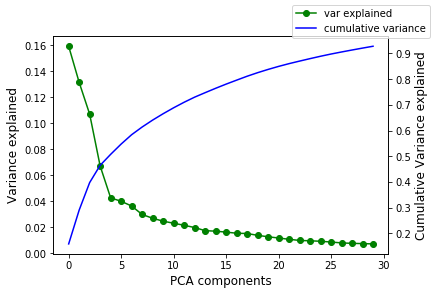

In [51]:
# Investigate the variance accounted for by each principal component.
var=pca.explained_variance_ratio_
cum_var=np.cumsum(var)
%matplotlib inline
fig, ax = plt.subplots()
ax2=ax.twinx()
ax.plot(var, label='var explained', color="green",marker="o")
ax2.plot(cum_var, label='cumulative variance', color="blue")
ax2.set_ylabel("Cumulative Variance explained",fontsize=12)
ax.set_ylabel("Variance explained",fontsize=12)
ax.set_xlabel("PCA components",fontsize=12)
fig.legend()

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
# the graph shows that eith 5 components we can explan about 50% of the variance 
pca = PCA(5, random_state=0)
pca.fit(X)
X_pca_transform = pca.transform(X)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

##### For my analysis I decide to work with 5 principal components. This 5 components explain about 50% of the total variance, which is considerble given that the intial number of columns were 55.  The basis of this analysis was the graph of the variance explaned as a function of PCA-component.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
col_names=azdias_data.columns
def weight_analysis(pca, component):
    res=pca.components_[component-1]
    positive=res>0
    res=np.abs(res)
    cols=col_names
    df_res=pd.DataFrame({'component':component, 'col names':cols,'weights':res, 'Positive?':positive})
    df_res=df_res.sort_values(by='weights', ascending=False)
    return(df_res)

weight=weight_analysis(pca, 1)
weight.head(3)

,component,col names,weights,Positive?
11,1,SEMIO_REL,0.297886,True
0,1,ALTERSKATEGORIE_GROB,0.280475,False
15,1,SEMIO_ERL,0.269737,False


In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight=weight_analysis(pca, 2)
weight.head(3)

,component,col names,weights,Positive?
43,2,ANREDE_KZ_2,0.305755,True
42,2,ANREDE_KZ_1,0.305755,False
13,2,SEMIO_VERT,0.303195,False


In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight=weight_analysis(pca, 3)
weight.head(3)

,component,col names,weights,Positive?
40,3,ORTSGR_KLS9,0.253279,True
52,3,household_wealth,0.249321,True
34,3,EWDICHTE,0.247979,True


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### The main contributors to the firstcomponent  are SEMIO_REL, ALTERSKATEGORIE_GROB, SEMIO_ERL. The three tend to describe the personality (low values high affinity): if the person is religious oriented (REL) or experience oriented (ERL). The orientation towards religion and experiences are opposed. Finally  ALTERSKATEGORIE_GROB gives a rough binning of ages based on the given name.

#### The main contributors to the third component are ANREDE_KZ_2, ANREDE_KZ_1, SEMIO_VERT. Interestingly this component relates to the sex of the person; male  ( ANREDE_KZ_1) and female are opposed (ANREDE_KZ_2) as would be expected. A person that is more dreamful (SEMIO_VERT, from high to low) is also represented in this vector. 

#### The main contributors to the third component  are ORTSGR_KLS9, household_wealth, and EWDICHTE. They describe the community size in inhabitants (ORTSGR_KLS9), the household wealth (from high to low), and the density of housholds per km2.  The three components are oriented in the same direction, meaning that people living in highly dense neighborhood, live in cities/towns with a larger number of inhabitants and there housholds are less wealthy.  


#### To summarize the first 3 principle components summarize the information concerning the personality and rough age, the sex and the houshold situation. This is quite enlightning, since it gives us  the very first information where we should focalise when doing the clustering.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [56]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
centers_v=[]
avg_dis=[]
for centers in range(2,15, 1): 
    
    #fit kmeans to get the labels
    kmeans = KMeans(centers, random_state=0)
    # run k-means clustering on the data and...
    kmeans.fit(X_pca_transform)
    # compute the average within-cluster distances.
    avg_dis.append(-1*kmeans.score(X_pca_transform).mean()/centers)
    centers_v.append(centers)

Text(0.5,0,'number of centroids')

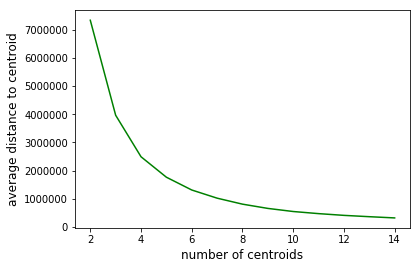

In [57]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
%matplotlib inline
plt.plot(centers_v, avg_dis, color="green")
plt.ylabel("average distance to centroid",fontsize=12)
plt.xlabel("number of centroids",fontsize=12)

In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(5, random_state=0)
kmeans.fit(X_pca_transform)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

#### The graph above shows that for more than 5 centroids the normalized distance (average distance divided by the number of centroids) starts to flatten out.  Of course, the more centroids the average distance decreases monotonously, but the normalization with the number of centroids allows a fair comparison. Therefore I decide to work with 5 centroids in the following.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [59]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
#Lets load the data again to be sure we treat both sets with exactly the same procedure
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [60]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_population=clean_data(azdias,  feat_info, drop_list_cols, max_na, list_1_hot_encode, drop_list_cat, drop_list_mixed, drop_list_cols_final)
df_customers=clean_data(customers,  feat_info, drop_list_cols, max_na, list_1_hot_encode, drop_list_cat, drop_list_mixed, drop_list_cols_final)
#standardize using the standard scaler from §3.1
df_population=df_population.dropna()
df_customers=df_customers.dropna()
X_population = std_scaler.transform(df_population)
X_customers = std_scaler.transform(df_customers)
#Use the same pca to transform the data
X_pca_population = pca.transform(X_population)
X_pca_customers = pca.transform(X_customers)

initial shape (891221, 85)
After introducing Nans (891221, 85)
Rows having Nans after conversion 829532
After droping cols (891221, 66)
After droping rows (793309, 66)
After categorical and mixed (793309, 55)
initial shape (191652, 85)
After introducing Nans (191652, 85)
Rows having Nans after conversion 157042
After droping cols (191652, 66)
After droping rows (138601, 66)
After categorical and mixed (138601, 55)


In [61]:
# predict using the kmeans fitted in §3.1
labels_population=pd.DataFrame({'labels':kmeans.predict(X_pca_population)})
labels_customers=pd.DataFrame({'labels':kmeans.predict(X_pca_customers)})

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# However for the normalization I take the total length of the data before removing the rows with NaNs 
labels_population_prop=pd.value_counts(labels_population['labels'].values, sort=False)/azdias.shape[0]
labels_customers_prop=pd.value_counts(labels_customers['labels'].values, sort=False)/customers.shape[0]

# lets add as a final cluster,those entries who were removed in the process of cleaning the data 
labels_customers_prop=labels_customers_prop.append(pd.Series([1-labels_customers_prop.sum()], index=[5]))
labels_population_prop=labels_population_prop.append(pd.Series([1-labels_population_prop.sum()], index=[5]))

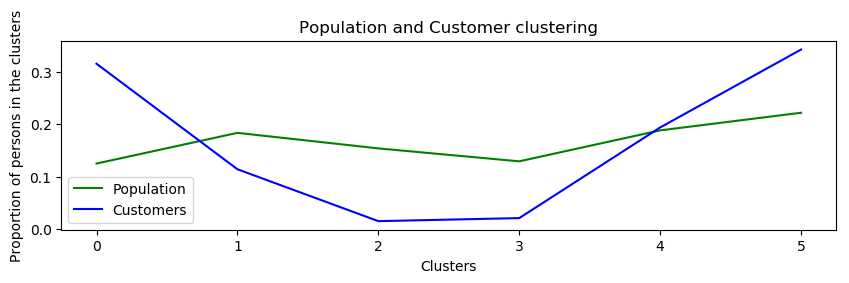

In [63]:
fig, ax = plt.subplots( figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
ax.plot(labels_population_prop, color = 'g', label='Population')
ax.plot(labels_customers_prop, color='b', label='Customers')
ax.set_title('Population and Customer clustering')
ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion of persons in the clusters')
ax.legend()

In [64]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# The cluster with label 1 is overrepresented in the customer set as compared to the population set 
# this cluster is mainly projected in the principal component 1, in a negative direcion. 
print(kmeans.cluster_centers_.astype(int)[0])

[-2 -1 -1  2  0]


#### The cluster labelled as 0, has a strong negative component in the first vecctor, and is negative in the second and third vectors. Following our previous analysis of the first components, it appears that this cluster includes people that:  are mostly oriented versus religion or culture, that are rather young, of the male sex, and that come from rather wealthy housholds located in not so dense communities.

In [65]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# the cluster labeled as 3 is underrepresented in the customer set compared to the population set
# this cluster is mainly projected on the second principal component 
print(kmeans.cluster_centers_.astype(int)[3])
print(kmeans.cluster_centers_.astype(int)[2])

[ 4 -1  0  0  0]
[ 2  3 -1  0  0]


##### Clusters labelled as 2 and 3 are underrepresented in the customer database. Following our previous analysis of the prinicipal components, we can say such clusters contain that women (second component of cluster 2) that are experience oriented (first component of both clusters) and living in not so densely populated area. 

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

### Analysis of Na removal
#### Our data cleaning procedure removed between 20 and 3% of the data. This is rather a large amount of data, however this stringent removal of entries and columns with too many Nas, allows us to make an analysis without any bias. For the future, it would be interesting to progressively reintroduce the data that were removed, and check if the clustering changes.

### Analysis of Population data
#### The last plot shows that the clusters of persons are almost equivalent in weight: the green line in the graph above is rather flat. This is good news because it shows that the overall set of people was taken from the whole population, meaning that we can interpret this set as a statsitically relavant set from the complete population ( lets recall that Germany has about 80 million inhabitants), and that we did not introduce some bias by only focusing on a particular population cluster.

### Analysis of the Customer data
#### With our analysis we could find 1 cluster that is over and 2 clusters that are underrepresented in the customer dataset when compared to the overall population data. With our analysis, we can say that the "typical" customer is a male person, living in a not so dense area, and interested religion. This might not eem such a big suprise, since Bertteslsman sells books, and most probably the  customers are educated persons, living in suburbian areas. Maybe more surprising was to find that females, more oriented towards experiences rather than culture are underrepsented in the customer base. Surely here there is some room for improvement: a marketing campaign could be started that adresses active women in the wealthy suburbain areas, pointing to the offerings of sport/outdoor content. Such a campaign targeting these persons appears to be a wise move towards expanding the market.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.